In [1]:
# Prepare Data

In [2]:
#-------------------------------------------------------------------------------------------------------------------
# Watershed Data 

In [3]:
import pandas as pd

# Read the watershed data
# This includes data from the watershed: Static data and Dynamic data
# Static data are characteristic of watershed which are constant,such as soil type, land use, etc
# Dynamic data are characteristic of watershed which are changing daily, such as rainfall and temperature.
watershed = r"C:\Users\Admin\Downloads\MakeUC\data\watershed_data.feather"
watershed = pd.read_feather(watershed)

# Filter out rows where 'ResultMeasureValue' is NaN
#ResultMesureValue is the Phosphorus Level 
# We considered 0.5mg/L as the maximum phosphorus level because anything above is an outlier observation
watershed = watershed[watershed['ResultMeasureValue'].notna()]
watershed = watershed[watershed['ResultMeasureValue'] <= 0.5]

# Group by 'reach', count the number of rows in each group
# Filter for reaches with more than 100 rows (adjust this threshold as needed)
# This helps to consider station with reliable data (more observations/ avoid stations that aren't reliable)
reach_counts = watershed.groupby('reach').size()
filtered_reaches = reach_counts[reach_counts > 100]

# Filter the original 'watershed' DataFrame based on these valid reaches
watershed = watershed[watershed['reach'].isin(filtered_reaches.index)]

# Since we are using data from different stations and time periods (spatial and temporal data),
# we need to consider data from all stations and across different years to train and test.
# The 'Q' column helps ensure we account for the spatial and temporal distribution while developing our ML model.
# This approach makes the model robust and helps us understand its accuracy.
# The code below retrieves data from both of these subsets.

location_1 = ['21PA_WQX-WQN0867', 'USGS-03374100', 'USGS-03609750', '21PA_WQX-WQN0901', 'USGS-03086000', 
              '21PA_WQX-WQN0801', '21PA_WQX-WQN0905'] # These are gauge station ID.

location_2 = ['21PA_WQX-WQN0906', '21PA_WQX-WQN0915', '21PA_WQX-WQN0701', '21PA_WQX-WQN0732', 
              '21PA_WQX-WQN0702', '21PA_WQX-WQN0706', '21PA_WQX-WQN0725']

# Use .apply() to assign the corresponding value based on the 'MonitoringLocationIdentifier'
watershed['Location_Q'] = watershed['MonitoringLocationIdentifier'].apply(
    lambda x: 1 if x in location_1 else (2 if x in location_2 else None)
)

# First, make sure the 'Time' column is in datetime format if it's not already
watershed['date'] = pd.to_datetime(watershed['date'])

# Assign values to 'Time_Q' based on the year
watershed['Time_Q'] = watershed['date'].apply(
    lambda x: 1 if x.year >= 2000 and x.year < 2010 else (2 if x.year >= 2010 else None)
)

watershed['Q'] = watershed['Location_Q'].astype(str) + watershed['Time_Q'].astype(str)


# "Filter" column helps to give index to station and measurement 
# This will be useful to ensure that we have enough test data with remote data for comparison
# This will help compare watershed based ML model and remote sensing based ML model accuracy
watershed['Filter'] = watershed['date'].astype(str) + watershed['MonitoringLocationIdentifier'].astype(str)

In [4]:
#-------------------------------------------------------------------------------------------------------------------
# Remote Sensing data

In [5]:
import pandas as pd

# Define file path
remote = r"C:\Users\Admin\Downloads\MakeUC\data\remotesensingdata.csv"
# Read CSV file
# Peforming similar data quality filteration (same as Watershed ML model)
remote = pd.read_csv(remote)
remote = remote[remote['ActivityStartDate']>= "2000-01-01"]
remote = remote[remote['ResultMeasureValue'] <= 0.5]
remote = remote[remote["MonitoringLocationIdentifier"].isin(watershed['MonitoringLocationIdentifier'])]

# Use .apply() to assign the corresponding value based on the 'MonitoringLocationIdentifier'
remote['Location_Q'] = remote['MonitoringLocationIdentifier'].apply(
    lambda x: 1 if x in location_1 else (2 if x in location_2 else None)
)

# First, make sure the 'Time' column is in datetime format if it's not already
remote['ActivityStartDate'] = pd.to_datetime(remote['ActivityStartDate'])

# Assign values to 'Time_Q' based on the year
remote['Time_Q'] = remote['ActivityStartDate'].apply(
    lambda x: 1 if x.year >= 2000 and x.year < 2010 else (2 if x.year >= 2010 else None)
)

# Concatenate 'Location_Q' and 'Time_Q' as strings
remote['Q'] = remote['Location_Q'].astype(str) + remote['Time_Q'].astype(str)

remote['Filter'] = remote['ActivityStartDate'].astype(str) + remote['MonitoringLocationIdentifier'].astype(str)


In [6]:
#-------------------------------------------------------------------------------------------------------------------
# Watershed data are available daily for each location.
# However, remote sensing data depend on the satellite’s orbit cycle.
# We are using Landsat, which has a 16-day revisit cycle.
# In many cases, remote sensing data are corrupted due to cloud cover, which limits our observations.
# Nevertheless, remote sensing data are valuable because they provide real-time, dynamic observations that enhance the accuracy of watershed models.

# Below code: This train and test division will ensure the we have enough observation 
# where we can compare the estimation accuracy of the remote sensing ML model and the watershed ML model 

remote_test = remote.sample(frac=0.3, random_state=42)
remote_train = remote.drop(remote_test.index)
#remote_test: 105*143 columns

watershed_remain = watershed[~watershed['Filter'].isin(remote_test['Filter'])]
watershed_remote_test = watershed[watershed['Filter'].isin(remote_test['Filter'])]
#watershed_remain: 2054*140
#watershed_remote_test: 102*140

watershed_test = watershed_remain.sample(frac=0.2, random_state=42)
watershed_train = watershed_remain.drop(watershed_test.index)
#watershed_train: 1438*140

# Assuming watershed_test and watershed_remote_test are pandas DataFrames
watershed_test_all = pd.concat([watershed_test, watershed_remote_test], ignore_index=True)
#watershed_test_all: 513*140

In [7]:
#-------------------------------------------------------------------------------------------------------------------
# ML Model Development 

In [8]:
#-------------------------------------------------------------------------------------------------------------------
# Watershed ML Model

# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature list for watershed model
watershed_features = [
    "precipitation", "area", "reach", "solar_radiation", "temperature_max", 
    "temperature_min", "Clay_0-5cm", "Clay_5-15cm", "Clay_15-30cm", 
    "Clay_30-60cm", "Clay_60-100cm", "Clay_100-200cm", "Sand_0-5cm", 
    "Sand_5-15cm", "Sand_15-30cm", "Sand_30-60cm", "Sand_60-100cm", 
    "Sand_100-200cm", "Silt_0-5cm", "Silt_5-15cm", "Silt_15-30cm", 
    "Silt_30-60cm", "Silt_60-100cm", "Silt_100-200cm", "SOC_0-5cm", 
    "SOC_5-15cm", "SOC_15-30cm", "SOC_30-60cm", "SOC_60-100cm", 
    "SOC_100-200cm", "year", "Shrub", "EH_Wetland", "Water", "Barren", 
    "Grassland", "Developed_HI", "W_Wetland", "Developed_LI", "Evergreen", 
    "Crops", "Developed_MI", "Pasture", "Deciduous", "Mixed", "Developed_Open"
]

# Select features and target from DataFrame
X = watershed_train[watershed_features]
y = watershed_train['ResultMeasureValue']

# Calculate correlations
watershed_data = pd.concat([X, y], axis=1)
correlations = watershed_data.corr()['ResultMeasureValue'].drop('ResultMeasureValue')
abs_correlations = correlations.abs().sort_values(ascending=False)

# Include specified features explicitly
extra_features = ['precipitation', 'temperature_max', 'temperature_min']
top_watershed_features = pd.concat([abs_correlations.head(15), abs_correlations[extra_features]]).drop_duplicates()

# Get names of top 20 features as a list
top_watershed_features = top_watershed_features.index.tolist()

# Prepare training and testing data
X_train = watershed_train[top_watershed_features]
y_train = watershed_train['ResultMeasureValue']
X_test = watershed_test_all[top_watershed_features]
y_test = watershed_test_all['ResultMeasureValue']

# Define pipeline with scaling and RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for tuning
param_grid = {
    'rf__n_estimators': [30, 50, 100, 200, 300, 500, 1000]
}

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

import joblib

# Save the best model to a file
joblib.dump(best_model, 'best_Watershed_model.pkl')


# Make predictions using the best model
y_pred = best_model.predict(X_test)
watershed_test_all['Watershed_estimate'] = y_pred

# Evaluate the model
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Best Parameters: {best_params}")
print(f"R-squared (R2): {r2}")


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Parameters: {'rf__n_estimators': 100}
R-squared (R2): 0.6195602283601328


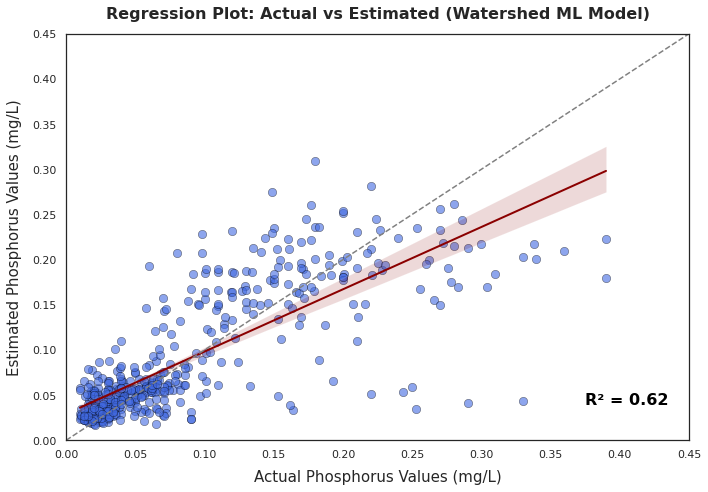

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

# Set seaborn style with no grid
sns.set(style="white")

# Create a regression plot
plt.figure(figsize=(10, 7))
sns.regplot(
    x=y_test, y=y_pred, 
    scatter_kws={'color': 'royalblue', 's': 70, 'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5}, 
    line_kws={'color': 'darkred', 'linewidth': 2}
)

# Add a diagonal line for reference
plt.plot([0, 0.45], [0, 0.45], color='gray', linestyle='--', linewidth=1.5)

# Set x and y limits
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)

# Add titles and labels
plt.title('Regression Plot: Actual vs Estimated (Watershed ML Model)', fontsize=16, weight='bold', pad=15)
plt.xlabel('Actual Phosphorus Values (mg/L)', fontsize=15, labelpad=10)
plt.ylabel('Estimated Phosphorus Values (mg/L)', fontsize=15, labelpad=10)

# Display R-squared value on the plot
plt.text(0.9, 0.1, f'R² = {r2:.2f}', fontsize=16, color='black', weight='bold',
         ha='center', va='center', transform=plt.gca().transAxes)

# Show the plot with a tighter layout
plt.tight_layout()
plt.show()


In [10]:
# -------------------------------------------------------------------------------------------------------------------
# Remote Sensing ML Model

# List of features
remotesensing_features = [
    'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 
    'BS', 'GS', 'RS', 'NS', 'R.GN', 'R.GB', 'R.GS', 'R.BN', 'R.BS', 'R.NS', 
    'G.BR', 'G.BN', 'G.BS', 'G.RN', 'G.RB', 'G.NS', 'B.RG', 'B.RN', 'B.RS', 
    'B.GN', 'B.GS', 'B.NS', 'N.RG', 'N.RB', 'N.RS', 'N.GB', 'N.GS', 'N.BS', 
    'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 
    'gn.gn', 'hue', 'saturation', 'bright', 'bright_tot', 'dw', 'hexcolor', 
    'mndwi', 'CVI', 'g.b.ndvi', 'r.b.ndvi', 'b3mb2', 'b2ab3', 'b2sb3', 'lnblue', 
    'lngreen', 'lnred', 'lnnir', 'p16', 'p17', 'p18', 'SABI', 'ngrdi', 'NDCI', 
    'gr2', 'grnir', 'nirSq', 'gnir', 'sw12', 'gswir1'
]

# Select the features and target from the DataFrame
X = remote_train[remotesensing_features]
y = remote_train['ResultMeasureValue']

# Compute the correlation between each feature and the target
correlations = X.corrwith(y)

# Get the absolute values of the correlations
abs_correlations = correlations.abs()

# Rank the features by the absolute correlation values in descending order
ranked_correlations = abs_correlations.sort_values(ascending=False)

# Select the top 20 features
top_remote_features = ranked_correlations.head(20)

# Convert the top 20 features into a list
top_remote_features_list = top_remote_features.index.tolist()

# Print the list of top 20 features
#print(top_remote_features_list)

# Assuming 'remote_train' is your DataFrame

# Define columns and target variable
columns = top_remote_features_list

X_train = remote_train[columns]  # Features
y_train = remote_train['ResultMeasureValue']  # Target

X_test = remote_test[columns]  # Features for testing (same as training)
y_test = remote_test['ResultMeasureValue']  # Target for testing

# Define the parameter grid for the number of estimators
param_grid = {
    'model__n_estimators': [30, 50, 100, 200, 300, 500, 1000]  # Define a range of estimators for tuning
}

# Create a pipeline that includes scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Feature scaling
    ('model', RandomForestRegressor(random_state=42))  # Step 2: RandomForest model
])

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, 'best_remote_model.pkl')

# Predict on the test data using the best model
y_pred = best_model.predict(X_test)
remote_test['Remote_estimate'] = y_pred

# Evaluate the model on test data
r2 = r2_score(y_test, y_pred)

print(f"Best Number of Estimators: {grid_search.best_params_['model__n_estimators']}")
print(f"R-squared: {r2}")

Best Number of Estimators: 500
R-squared: 0.6083094110869871


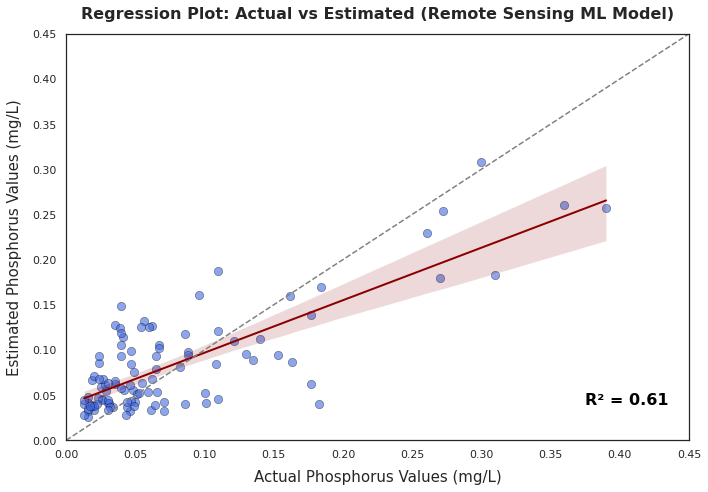

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

# Set seaborn style with no grid
sns.set(style="white")

# Create a regression plot
plt.figure(figsize=(10, 7))
sns.regplot(
    x=y_test, y=y_pred, 
    scatter_kws={'color': 'royalblue', 's': 70, 'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5}, 
    line_kws={'color': 'darkred', 'linewidth': 2}
)

# Add a diagonal line for reference
plt.plot([0, 0.45], [0, 0.45], color='gray', linestyle='--', linewidth=1.5)

# Set x and y limits
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)

# Add titles and labels
plt.title('Regression Plot: Actual vs Estimated (Remote Sensing ML Model)', fontsize=16, weight='bold', pad=15)
plt.xlabel('Actual Phosphorus Values (mg/L)', fontsize=15, labelpad=10)
plt.ylabel('Estimated Phosphorus Values (mg/L)', fontsize=15, labelpad=10)

# Display R-squared value on the plot
plt.text(0.9, 0.1, f'R² = {r2:.2f}', fontsize=16, color='black', weight='bold',
         ha='center', va='center', transform=plt.gca().transAxes)

# Show the plot with a tighter layout
plt.tight_layout()
plt.show()


In [12]:
# Combined Performance 

In [13]:
watershed_estimates = watershed_test_all[['Watershed_estimate', 'date', 'MonitoringLocationIdentifier', 'ResultMeasureValue']]
remote_estimates = remote_test[['Remote_estimate', 'ActivityStartDate', 'MonitoringLocationIdentifier']]

# Merging the two dataframes on 'date' and 'MonitoringLocationIdentifier'
combined_remote_watershed = pd.merge(watershed_estimates, remote_estimates, left_on=['date', 'MonitoringLocationIdentifier'], 
                    right_on=['ActivityStartDate', 'MonitoringLocationIdentifier'], how='inner')

In [14]:
combined_remote_watershed

,Watershed_estimate,date,MonitoringLocationIdentifier,ResultMeasureValue,Remote_estimate,ActivityStartDate
0,0.024325,2000-04-14,21PA_WQX-WQN0867,0.0300,0.063359,2000-04-14
1,0.025090,2009-05-19,21PA_WQX-WQN0867,0.0170,0.037461,2009-05-19
2,0.026275,2010-06-22,21PA_WQX-WQN0867,0.0160,0.025916,2010-06-22
3,0.028895,2011-06-01,21PA_WQX-WQN0867,0.0350,0.127290,2011-06-01
4,0.027415,2011-08-11,21PA_WQX-WQN0867,0.0160,0.040762,2011-08-11
...,...,...,...,...,...,...
99,0.027300,2016-06-15,21PA_WQX-WQN0725,0.0130,0.027613,2016-06-15
100,0.062430,2017-03-28,21PA_WQX-WQN0725,0.0660,0.053444,2017-03-28
101,0.036330,2017-06-26,21PA_WQX-WQN0725,0.0515,0.051715,2017-06-26
102,0.031290,2019-10-28,21PA_WQX-WQN0725,0.0340,0.036518,2019-10-28


In [15]:
from sklearn.metrics import r2_score
import numpy as np  # If using np.mean

# Compute R-squared between 'ResultMeasureValue' and 'Watershed_estimate'
r2_watershed = r2_score(combined_remote_watershed['ResultMeasureValue'], combined_remote_watershed['Watershed_estimate'])

# Compute R-squared between 'ResultMeasureValue' and 'Remote_estimate'
r2_remote = r2_score(combined_remote_watershed['ResultMeasureValue'], combined_remote_watershed['Remote_estimate'])

# Compute R-squared between 'ResultMeasureValue' and the mean of 'Remote_estimate' and 'Watershed_estimate'
r2_combined = r2_score(combined_remote_watershed['ResultMeasureValue'], 
                       np.mean([combined_remote_watershed['Remote_estimate'], combined_remote_watershed['Watershed_estimate']], axis=0))

print(f'R-squared between ResultMeasureValue and Watershed_estimate: {r2_watershed}')
print(f'R-squared between ResultMeasureValue and Remote_estimate: {r2_remote}')
print(f'R-squared between ResultMeasureValue and combined estimates (Remote + Watershed): {r2_combined}')


R-squared between ResultMeasureValue and Watershed_estimate: 0.6221041217626242
R-squared between ResultMeasureValue and Remote_estimate: 0.6180078822526806
R-squared between ResultMeasureValue and combined estimates (Remote + Watershed): 0.7258951647837071


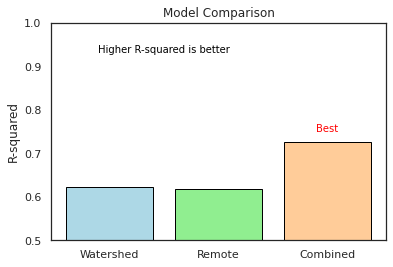

In [16]:
# Create a bar plot with outlined bars
r2_values = [r2_watershed, r2_remote, r2_combined]
labels = ['Watershed', 'Remote', 'Combined']

# Use valid color names and outline the bars with 'black' or any desired color
bars = plt.bar(labels, r2_values, color=['lightblue', 'lightgreen', '#FFCC99'], edgecolor='black')  # Adding black outline
plt.ylabel('R-squared')
plt.title('Model Comparison')
plt.ylim([0.5, 1])  # Set y-axis limit from 0.5 to 1 for better comparison

# Add a comment to the plot indicating that higher is better
plt.text(0.5, 0.95, 'Higher R-squared is better', ha='center', va='top', fontsize=10, color='black')

# Add "Best" label over the "Combined" bar
plt.text(bars[2].get_x() + bars[2].get_width() / 2, bars[2].get_height() + 0.02, 'Best', 
         ha='center', va='bottom', fontsize=10, color='red')

plt.show()


Percent Bias between ResultMeasureValue and Watershed_estimate: 4.385071613351007
Percent Bias between ResultMeasureValue and Remote_estimate: -8.856981703317045
Percent Bias between ResultMeasureValue and combined estimates (Remote + Watershed): -2.2359550449830197


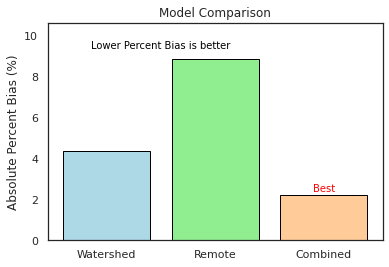

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Compute Percent Bias for Watershed_estimate
pbias_watershed = np.sum(combined_remote_watershed['ResultMeasureValue'] - combined_remote_watershed['Watershed_estimate']) / np.sum(combined_remote_watershed['ResultMeasureValue']) * 100

# Compute Percent Bias for Remote_estimate
pbias_remote = np.sum(combined_remote_watershed['ResultMeasureValue'] - combined_remote_watershed['Remote_estimate']) / np.sum(combined_remote_watershed['ResultMeasureValue']) * 100

# Compute Percent Bias for combined estimates (Remote + Watershed)
combined_estimate = np.mean([combined_remote_watershed['Remote_estimate'], combined_remote_watershed['Watershed_estimate']], axis=0)
pbias_combined = np.sum(combined_remote_watershed['ResultMeasureValue'] - combined_estimate) / np.sum(combined_remote_watershed['ResultMeasureValue']) * 100

# Print the results
print(f'Percent Bias between ResultMeasureValue and Watershed_estimate: {pbias_watershed}')
print(f'Percent Bias between ResultMeasureValue and Remote_estimate: {pbias_remote}')
print(f'Percent Bias between ResultMeasureValue and combined estimates (Remote + Watershed): {pbias_combined}')

# Create a bar plot for Absolute Percent Bias (PBIAS)
pbias_values = [abs(pbias_watershed), abs(pbias_remote), abs(pbias_combined)]  # Absolute PBIAS values
labels = ['Watershed', 'Remote', 'Combined']

# Create the bar plot
bars = plt.bar(labels, pbias_values, color=['lightblue', 'lightgreen', '#FFCC99'], edgecolor='black')
plt.ylabel('Absolute Percent Bias (%)')
plt.title('Model Comparison')
plt.ylim([0, max(pbias_values) * 1.2])  # Set y-axis limit with some margin

# Add a comment to the plot indicating that lower is better
plt.text(0.5, max(pbias_values) * 1.1, 'Lower Percent Bias is better', ha='center', va='top', fontsize=10, color='black')

# Add "Best" label over the "Combined" bar
plt.text(bars[2].get_x() + bars[2].get_width() / 2, bars[2].get_height() + 0.02, 'Best', 
         ha='center', va='bottom', fontsize=10, color='red')

plt.show()


In [18]:
combined_remote_watershed['Combined_estimate'] = combined_estimate

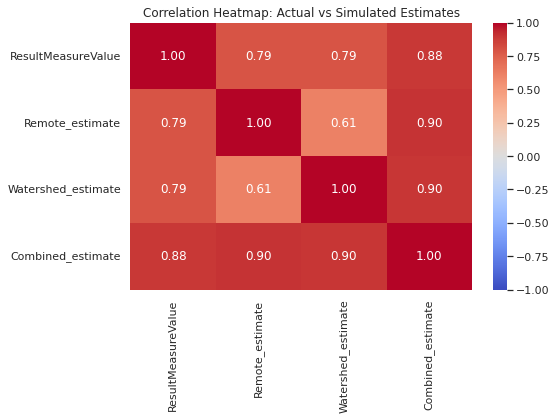

In [19]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = combined_remote_watershed[['ResultMeasureValue', 'Remote_estimate', 'Watershed_estimate', 'Combined_estimate']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Actual vs Simulated Estimates')
plt.tight_layout()
plt.show()


In [20]:
# Function to calculate R-squared for each MonitoringLocationIdentifier and count the rows
def calculate_r2_for_group(group):
    r2_watershed = r2_score(group['ResultMeasureValue'], group['Watershed_estimate'])
    r2_remote = r2_score(group['ResultMeasureValue'], group['Remote_estimate'])
    r2_combine = r2_score(group['ResultMeasureValue'], group['Combined_estimate'])
    count_rows = len(group)
    return pd.Series({'R2_Watershed': r2_watershed, 'R2_Remote': r2_remote, 'R2_Combined': r2_combine, 'Count': count_rows})

# Group by MonitoringLocationIdentifier and apply the R² calculation
r2_results = combined_remote_watershed.groupby('MonitoringLocationIdentifier').apply(calculate_r2_for_group)


                              R2_Watershed  R2_Remote  R2_Combined  Count
MonitoringLocationIdentifier                                             
21PA_WQX-WQN0701                 -0.083516  -1.551974     0.354783    7.0
21PA_WQX-WQN0702                  0.084212  -0.447128     0.200379    5.0
21PA_WQX-WQN0706                  0.300591  -1.345796    -0.154497    5.0
21PA_WQX-WQN0725                 -0.952580  -0.233722    -0.467115   10.0
21PA_WQX-WQN0732                 -0.147324   0.348852     0.531143    8.0
21PA_WQX-WQN0801                -10.155523 -88.358783   -36.826555    4.0
21PA_WQX-WQN0867                  0.275141  -5.264960    -0.655977   10.0
21PA_WQX-WQN0901                  0.349726  -3.929122    -0.837512    5.0
21PA_WQX-WQN0905                 -1.417781  -4.864832    -2.013396    4.0
21PA_WQX-WQN0906                 -0.900489  -1.799302    -0.352686    5.0
USGS-03086000                    -0.251709  -5.111069    -1.286981   11.0
USGS-03374100                    -0.10

In [21]:
from scipy.stats import pearsonr

# Function to calculate correlation for each MonitoringLocationIdentifier and count the rows
def calculate_correlation_for_group(group):
    corr_watershed, _ = pearsonr(group['ResultMeasureValue'], group['Watershed_estimate'])
    corr_remote, _ = pearsonr(group['ResultMeasureValue'], group['Remote_estimate'])
    corr_combine, _ = pearsonr(group['ResultMeasureValue'], group['Combined_estimate'])
    count_rows = len(group)
    return pd.Series({'Corr_Watershed': corr_watershed, 'Corr_Remote': corr_remote, 'Corr_Combined': corr_combine, 'Count': count_rows})

# Group by MonitoringLocationIdentifier and apply the correlation calculation
correlation_results = combined_remote_watershed.groupby('MonitoringLocationIdentifier').apply(calculate_correlation_for_group)


                              Corr_Watershed  Corr_Remote  Corr_Combined  \
MonitoringLocationIdentifier                                               
21PA_WQX-WQN0701                    0.229641     0.791453       0.806187   
21PA_WQX-WQN0702                    0.769005     0.264693       0.485909   
21PA_WQX-WQN0706                    0.924900    -0.693392      -0.222807   
21PA_WQX-WQN0725                    0.216174     0.428153       0.307255   
21PA_WQX-WQN0732                    0.033762     0.887089       0.843608   
21PA_WQX-WQN0801                    0.056929     0.578733       0.557354   
21PA_WQX-WQN0867                    0.549538     0.735266       0.791516   
21PA_WQX-WQN0901                    0.678247    -0.108397       0.030881   
21PA_WQX-WQN0905                    0.633685    -0.590967       0.024946   
21PA_WQX-WQN0906                    0.140294    -0.720258      -0.416455   
USGS-03086000                       0.220557     0.717352       0.684725   
USGS-0337410

In [22]:

# Result
#------------------------------------------------------------------------------------------------------------------------------
## Station Peformance for one of the stations


In [23]:
import pandas as pd

# Load the data
watershed = pd.read_feather(r"C:\Users\Admin\Downloads\MakeUC\data\watershed_data.feather")
remote = pd.read_csv(r"C:\Users\Admin\Downloads\MakeUC\data\remotesensingdata.csv")

# Assuming 'MonitoringLocationIdentifier' is a column in both datasets
station_data = watershed[watershed['MonitoringLocationIdentifier'] == '21PA_WQX-WQN0701']
remote_date = remote[remote['MonitoringLocationIdentifier'] == '21PA_WQX-WQN0701']
# Monongahela_river


# Select the features based on column names from the respective datasets
station_features = station_data[top_watershed_features]
remote_features = remote_date[top_remote_features_list]


In [24]:
# Load the model from the file (Watershed Estimate)
best_watershed_model = joblib.load("/N/lustre/project/proj-212/Ramtelpp/MakeUC/Final_SRC/best_Watershed_model.pkl")
TP_estimate_Watershed = best_watershed_model.predict(station_features)
Watershed_date = station_data[['date', 'ResultMeasureValue']].copy()
Watershed_date.loc[:, 'Watershed_Estimate'] = TP_estimate_Watershed


In [25]:
# Load the model from the file
best_remote_model = joblib.load("/N/lustre/project/proj-212/Ramtelpp/MakeUC/Final_SRC/best_remote_model.pkl")
TP_estimate_Remote = best_remote_model.predict(remote_features)
# Ensure remote_date is a copy if it is a slice of another DataFrame
remote_date = remote_date.copy()
remote_date['Remote_Estimate'] = TP_estimate_Remote
remote_date = remote_date[['Remote_Estimate','ActivityStartDate' ]]


In [26]:
# Convert both 'date' and 'ActivityStartDate' to datetime format
Watershed_date['date'] = pd.to_datetime(Watershed_date['date'])
remote_date['ActivityStartDate'] = pd.to_datetime(remote_date['ActivityStartDate'])

# Merge the two DataFrames on the specified columns
Overall_data = Watershed_date.merge(remote_date, how='left', left_on='date', right_on='ActivityStartDate')

# Calculate the mean estimate by backfilling missing values (left to right)
Overall_data['Mean_Estimate'] = Overall_data[['Remote_Estimate', 'Watershed_Estimate']].bfill(axis=1).mean(axis=1)


In [27]:
Overall_data.to_csv("Monongahela_river.csv")


In [28]:
remote_date

,Remote_Estimate,ActivityStartDate
134,0.033500,2014-01-16
135,0.070827,2013-11-13
136,0.034759,2012-04-24
137,0.061659,2017-07-19
138,0.052469,2000-08-21
1244,0.054607,2014-07-10
1245,0.034062,2015-03-31
1246,0.068197,2012-06-26
1247,0.034606,2009-04-15
1248,0.078641,2010-01-20


[CV] END ................................rf__n_estimators=30; total time=   0.1s
[CV] END ................................rf__n_estimators=30; total time=   0.1s
[CV] END ................................rf__n_estimators=30; total time=   0.1s
[CV] END ................................rf__n_estimators=50; total time=   0.2s
[CV] END ................................rf__n_estimators=50; total time=   0.2s
[CV] END ................................rf__n_estimators=50; total time=   0.2s
[CV] END ...............................rf__n_estimators=100; total time=   0.4s
[CV] END ...............................rf__n_estimators=100; total time=   0.4s
[CV] END ...............................rf__n_estimators=100; total time=   0.4s
[CV] END ...............................rf__n_estimators=200; total time=   0.8s
[CV] END ...............................rf__n_estimators=200; total time=   0.8s
[CV] END ...............................rf__n_estimators=200; total time=   0.9s
[CV] END ...................